In [1]:
import numpy as np

Implementation Decisions:
- Created a World class representing a 10×10 grid world with:
- start and goal positions
- hazards representing unsafe states
- step_penalty to encourage shorter paths
- Implemented coordinate conversion methods (xy2idx and idx2xy) to map between - 2D grid positions and 1D Q-table indices.
- reset() allows for fixed or random start positions.
- step(action) executes an action (UP/DOWN/LEFT/RIGHT) with boundary checks and computes reward.

Design Choices:
- Used a set for hazards for efficient membership checking.
- Reward structure:
- Hazard: -10 (terminal)
- Goal: +10 (terminal)
- Normal step: step penalty (-0.1 or -1)
- Render method prints a textual grid for visualization.

In [2]:
class World(object): 
    def __init__(self, x=10, y=10, step_penalty=-0.1, random_start=False):
        self.x = x
        self.y = y
        self.R = np.zeros(self.x * self.y)
        self.step_penalty = step_penalty
        self.random_start = random_start

        # Grid setup
        self.start = (0, 0)
        self.goal = (9, 9)
        self.hazards = {
            (0,3), (1,1),(1,7), (2,4), (2,8),
            (3,2), (3,6), (4,5), (5,3), (5,8),
            (6,1), (6,6), (7,4), (8,2), (8,7)
        }

        self.reset()
    
    #Cordinate conversion because Q-table uses state index
    def idx2xy(self, idx):
        x = int (idx/ self.y)
        y = idx % self.y
        return x, y
    
    def xy2idx(self, x, y):
        return x * self.y + y

    #Return the inital state
    def reset(self):
        """Reset agent position (fixed or random start)."""
        if self.random_start == True:
            safe_positions = [
                (r, c)
                for r in range(self.x)
                for c in range(self.y)
                if (r, c) not in self.hazards and (r, c) != self.goal
            ]
            self.agent_pos = random.choice(safe_positions)
        else:
            self.agent_pos = self.start
        
        self.agentPos = self.xy2idx(*self.agent_pos)
        return self.agent_pos
    
    #Reward
    def setReward(self, x, y, r):
        idx = self.xy2idx(x, y)
        self.R[idx] = r

    def getReward(self):
        """Return reward based on current agent position."""
        if self.agent_pos in self.hazards:
            return -10, True  # hazard -> terminal
        elif self.agent_pos == self.goal:
            return 10, True   # goal -> terminal
        else:
            return self.step_penalty, False  # normal step

    #Execute an action

    #Check move:
    def validMove(self, x, y):
        """Check if move is within grid boundaries."""
        return 0 <= x < self.x and 0 <= y < self.y
    
    def step(self, action_id):
        """Move agent according to action (0=UP,1=DOWN,2=LEFT,3=RIGHT)."""
        r, c = self.agent_pos

        if action_id == 0:   # UP
            r -= 1
        elif action_id == 1: # DOWN
            r += 1
        elif action_id == 2: # LEFT
            c -= 1
        elif action_id == 3: # RIGHT
            c += 1
        else:
            raise ValueError("Invalid action ID")

        # Check validity
        if self.validMove(r, c):
            self.agent_pos = (r, c)

        self.agentPos = self.xy2idx(*self.agent_pos)
        reward, done = self.getReward()
        return self.agent_pos, reward, done
    
    def getNumOfStates(self):
        return self.x * self.y
    
    def getNumOfActions(self):
        return 4

    #Visualise current state:
    def render(self):
        grid = [[" . " for _ in range(self.y)] for _ in range(self.x)]

        for (r, c) in self.hazards: grid[r][c] = " H "
        gr, gc = self.goal; grid[gr][gc] = " G "
        ar, ac = self.idx2xy(self.agentPos); grid[ar][ac] = " A "

        print("\nGrid World:")
        for row in grid: print("".join(row))
        print()

In [3]:
#Check task 1
env = World(random_start=False)
env.render()

obs, r, done = env.step(3)  # RIGHT
env.render()
print(obs, r, done)


Grid World:
 A  .  .  H  .  .  .  .  .  . 
 .  H  .  .  .  .  .  H  .  . 
 .  .  .  .  H  .  .  .  H  . 
 .  .  H  .  .  .  H  .  .  . 
 .  .  .  .  .  H  .  .  .  . 
 .  .  .  H  .  .  .  .  H  . 
 .  H  .  .  .  .  H  .  .  . 
 .  .  .  .  H  .  .  .  .  . 
 .  .  H  .  .  .  .  H  .  . 
 .  .  .  .  .  .  .  .  .  G 


Grid World:
 .  A  .  H  .  .  .  .  .  . 
 .  H  .  .  .  .  .  H  .  . 
 .  .  .  .  H  .  .  .  H  . 
 .  .  H  .  .  .  H  .  .  . 
 .  .  .  .  .  H  .  .  .  . 
 .  .  .  H  .  .  .  .  H  . 
 .  H  .  .  .  .  H  .  .  . 
 .  .  .  .  H  .  .  .  .  . 
 .  .  H  .  .  .  .  H  .  . 
 .  .  .  .  .  .  .  .  .  G 

(0, 1) -0.1 False


## Task 2: Q-Learning Agent with Step Penalty Comparison

Implementation Decisions:
•	Implemented QAgent class:
•	Q-table initialized as zeros (state × action)
•	Epsilon-greedy exploration
•	Q-learning update: Q[s, a] += α*(reward + γ*max(Q[s2]) - Q[s, a])
•	Trained for two step penalties: -1.0 (harsh) and -0.1 (gentle).

Design Choices:
•	Parameters chosen based on preliminary experiments:
•	α=0.1, γ=0.99
•	Epsilon starts high (1.0) and decays to encourage exploration early
•	Recorded metrics per episode: rewards, episode lengths, safety violations, success rate.

In theory:
•	Gentle penalty (-0.1) leads to higher cumulative rewards and more successful episodes.
•	Harsh penalty (-1.0) discourages long exploration, resulting in fewer steps but lower success.
•	Step penalty significantly affects exploration-exploitation balance.

However, my results show similar trends for both penalty, however -1.0 have a negative average results.

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque

class QAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99,
                 epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        
        self.env = env
        self.nS = env.getNumOfStates()
        self.nA = env.getNumOfActions()

        self.Q = np.zeros((self.nS, self.nA)) #Q-table (state x action) - we start with no knowledge

        # params
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon #probability of taking random action
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # logs for plotting & evaluation performance
        self.rewards = []
        self.lengths = []
        self.violations = []
        self.success = []

    def choose_action(self, s):
        if random.random() < self.epsilon:
            return random.randint(0, self.nA-1)
        return np.argmax(self.Q[s])

    def train(self, episodes=2000, max_steps=200):
        for ep in range(episodes):
            self.env.random_start = True
            self.env.reset()
            s = self.env.agentPos
            done = False

            total_reward = 0
            steps = 0
            ep_viol = 0

            while not done and steps < max_steps:
                a = self.choose_action(s)
                _, reward, done = self.env.step(a)
                s2 = self.env.agentPos

                # Count dangerous actions
                if reward == -10:
                    ep_viol += 1

                # Q-update (Q-learning)
                self.Q[s, a] += self.alpha * (
                    reward + self.gamma * np.max(self.Q[s2]) - self.Q[s, a]
                )

                s = s2
                steps += 1
                total_reward += reward

            # decay ε - reduce exploration - become more greedy
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            self.rewards.append(total_reward)
            self.lengths.append(steps)
            self.violations.append(ep_viol)
            self.success.append(1 if reward == 10 else 0)

In [5]:
def smooth(data, window=50):
    dq = deque(maxlen=window)
    out = []
    for x in data:
        dq.append(x)
        out.append(np.mean(dq))
    return out

penalties = [-1.0, -0.1] 
results_task2 = {}

for pen in penalties:
    print(f"Training with step penalty = {pen}")
    env = World(10,10, step_penalty=pen, random_start=True)
    agent = QAgent(env, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.995)
    agent.train(episodes=2000)
    results_task2[pen] = agent



Training with step penalty = -1.0
Training with step penalty = -0.1


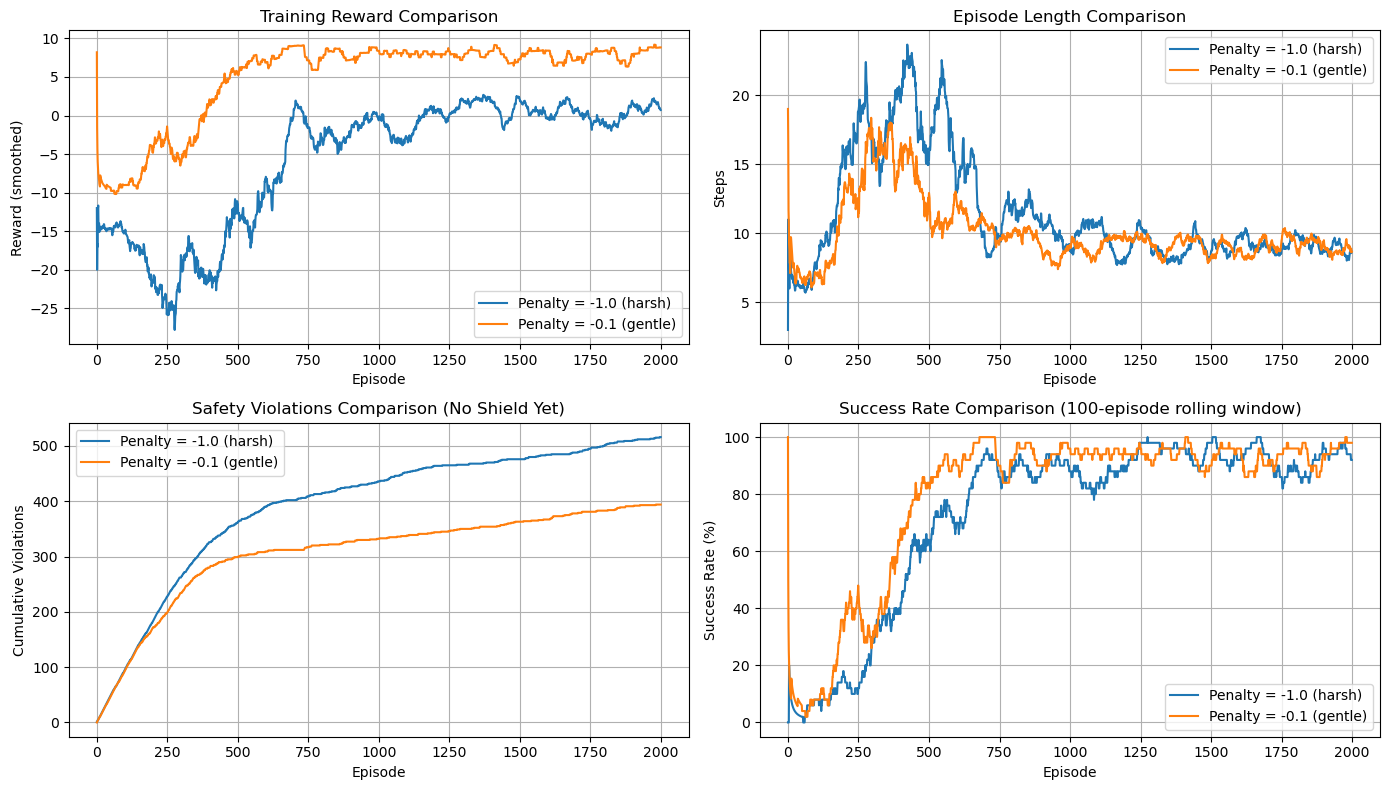

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(14,8))

for pen, agent in results_task2.items():
    lbl = f"Penalty = {pen} ({'harsh' if pen==-1.0 else 'gentle'})"

    axs[0,0].plot(smooth(agent.rewards), label=lbl)
    axs[0,0].set_title("Training Reward Comparison")
    axs[0,0].set_ylabel("Reward (smoothed)")

    axs[0,1].plot(smooth(agent.lengths), label=lbl)
    axs[0,1].set_title("Episode Length Comparison")
    axs[0,1].set_ylabel("Steps")

    axs[1,0].plot(np.cumsum(agent.violations), label=lbl)
    axs[1,0].set_title("Safety Violations Comparison (No Shield Yet)")
    axs[1,0].set_ylabel("Cumulative Violations")

    axs[1,1].plot(smooth(np.array(agent.success)*100), label=lbl)
    axs[1,1].set_title("Success Rate Comparison (100-episode rolling window)")
    axs[1,1].set_ylabel("Success Rate (%)")

for ax in axs.flat:
    ax.set_xlabel("Episode")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

In [8]:
table = []

for pen, agent in results_task2.items():
    success_rate = np.mean(agent.success) * 100
    avg_reward = np.mean(agent.rewards)
    avg_length = np.mean(agent.lengths)
    total_viol = np.sum(agent.violations)

    table.append({
        "Step Penalty": pen,
        "Success Rate (%)": f"{success_rate:.1f}",
        "Avg Reward": f"{avg_reward:.2f}",
        "Avg Episode Length": f"{avg_length:.1f}",
        "Total Violations": int(total_viol),
    })

df = pd.DataFrame(table)
df


,Step Penalty,Success Rate (%),Avg Reward,Avg Episode Length,Total Violations
0,-1.0,74.2,-5.55,11.4,516
1,-0.1,80.3,5.15,10.1,394


## Task 3: Danger Map and Dataset Generation
Implementation Decisions:
- Computed danger map D(s) using BFS from all hazard cells.
- Generated dataset of (state, action) → risk class:
- Risk classes based on min steps to hazard:
- 0: hazard
- 1: distance 1
- 2: distance 2
- 3: distance ≥ 3
- Feature vector (10-dimensions) per state-action:
- Current position (x, y) normalized
- One-hot encoded action
- Next position (x′, y′) normalized
- Danger levels for current and next states

Design Choices:
- Ignored hazard and goal states in dataset to focus on decision-making in safe areas.
- Normalized features to [0,1] for neural network stability.
- Split dataset into train (70%), validation (15%), test (15%).




In [10]:
#Redo task 3
from collections import deque
import numpy as np
import pickle
from sklearn.model_selection import train_test_split

def compute_danger_map(env):
    n = env.x
    D = {}
    q = deque()

    # Initialize hazards with distance 0
    for h in env.hazards:
        D[h] = 0
        q.append(h)

    # BFS from all hazards
    while q:
        r, c = q.popleft()
        d = D[(r, c)]

        for dr, dc in [(-1,0),(1,0),(0,-1),(0,1)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < n and 0 <= nc < n and (nr, nc) not in D:
                D[(nr, nc)] = d + 1
                q.append((nr, nc))

    return D

In [11]:
def show_danger_map(D, n=10):
    M = np.zeros((n, n), dtype=int)
    for (r, c), d in D.items():
        M[r, c] = d
    plt.figure(figsize=(4,4))
    plt.imshow(M, origin='upper')
    plt.colorbar(label="min steps to hazard")
    plt.title("Danger Map D(s)")
    plt.show()

In [12]:
def next_pos(env, r, c, action):
    nr, nc = r, c
    if action == 0: nr -= 1   # UP
    elif action == 1: nr += 1 # DOWN
    elif action == 2: nc -= 1 # LEFT
    elif action == 3: nc += 1 # RIGHT

    # boundary check
    if 0 <= nr < env.x and 0 <= nc < env.y:
        return nr, nc
    return r, c

def label_from_D(d):
    if d == 0: return 0
    if d == 1: return 1
    if d == 2: return 2
    return 3

def build_dataset(env, D):
    data = []
    n = env.x

    for r in range(env.x):
        for c in range(env.y):

            if (r, c) in env.hazards or (r, c) == env.goal:
                continue

            for action in [0,1,2,3]:   # UP,DOWN,LEFT,RIGHT
                r2, c2 = next_pos(env, r, c, action)
                y = label_from_D(D[(r2, c2)])

                d_cur = D[(r, c)]
                d_next = D[(r2, c2)]

                # Construct 10-dimensional feature vector
                x = np.array([
                    r/n, c/n,                # 1-2: current pos
                    1 if action==0 else 0,   # 3-6: one-hot action
                    1 if action==1 else 0,
                    1 if action==2 else 0,
                    1 if action==3 else 0,
                    r2/n, c2/n,              # 7-8: next pos
                    d_cur/n,                 # 9: danger current
                    d_next/n                 # 10: danger next
                ], dtype=np.float32)

                data.append((x, y))

    return data

# Build dataset
env = World(step_penalty=-0.1, random_start=False)
D = compute_danger_map(env)
dataset = build_dataset(env, D)

X = np.array([x for x,_ in dataset])
y = np.array([y for _,y in dataset])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

dataset_dict = {
    "X_train":X_train, "y_train":y_train,
    "X_val":X_val, "y_val":y_val,
    "X_test":X_test, "y_test":y_test,
    "danger_map":D
}

with open("complete_dataset.pkl","wb") as f:
    pickle.dump(dataset_dict,f)

print("Total samples:", len(dataset))
print("Class counts:", {i: sum(y==i) for i in range(4)})

Total samples: 336
Class counts: {0: 59, 1: 161, 2: 94, 3: 22}


## Task 4: Implementation Decisions:
Neural network with 2 hidden layers (64 units each, ReLU) and softmax output (4 risk classes).
Categorical cross-entropy loss with Adam optimizer.
One-hot encoded target labels for training.

Design Choices:
Input: 10-dimensional feature vector
Output: risk class probabilities
Early experiments showed 64 units per layer sufficient for perfect accuracy on this small grid dataset.

In [13]:
import pickle
import numpy as np

with open("complete_dataset.pkl", "rb") as f:
    data = pickle.load(f)

X_train, y_train = data["X_train"], data["y_train"]
X_val, y_val     = data["X_val"], data["y_val"]
X_test, y_test   = data["X_test"], data["y_test"]

In [14]:
from tensorflow.keras.utils import to_categorical
#One-hot encode
y_train_oh = to_categorical(y_train, num_classes=4)
y_val_oh   = to_categorical(y_val,   num_classes=4)
y_test_oh  = to_categorical(y_test,  num_classes=4)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(64, activation='relu', input_shape=(10,)),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,124 (20.02 KB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(
    X_train, y_train_oh,
    validation_data=(X_val, y_val_oh),
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2460 - loss: 1.3848 - val_accuracy: 0.4400 - val_loss: 1.3322
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4643 - loss: 1.3172 - val_accuracy: 0.4800 - val_loss: 1.2865
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4659 - loss: 1.2732 - val_accuracy: 0.4800 - val_loss: 1.2516
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4918 - loss: 1.2362 - val_accuracy: 0.4800 - val_loss: 1.2297
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4895 - loss: 1.2056 - val_accuracy: 0.4800 - val_loss: 1.2164
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4585 - loss: 1.1958 - val_accuracy: 0.4800 - val_loss: 1.2065
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4494 - loss: 1.2031 - val_accuracy: 0.4800 - val_loss: 1.2005
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4979 - loss: 1.1492 - val_accuracy: 0.4800 - val_loss: 1.1947

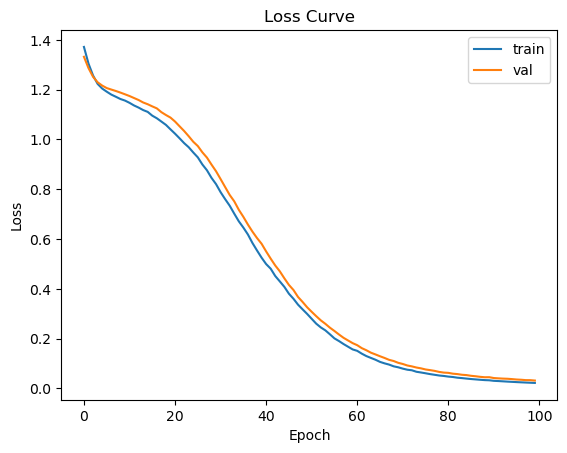

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
✅ Test accuracy: 1.0


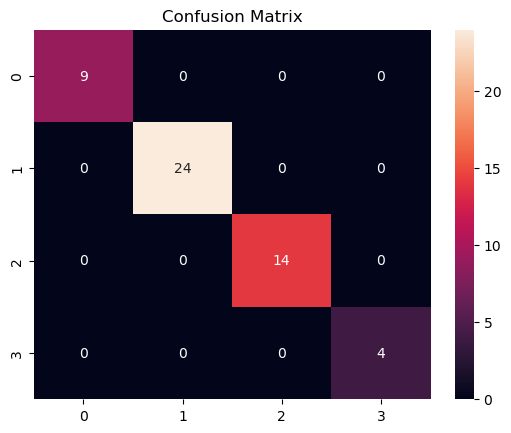

✅ Safety shield model saved


In [17]:
# Loss plot
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns


plt.plot(history.history['loss'], label="train")
plt.plot(history.history['val_loss'], label="val")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluate
y_pred = np.argmax(model.predict(X_test), axis=1)
acc = accuracy_score(y_test, y_pred)
print("✅ Test accuracy:", acc)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()

model.save("safety_shield.h5")
print("✅ Safety shield model saved")

## Task 5: Shielded Q-Learning

Implementation Decisions:
- Implemented shielded_action():
- Evaluates all 4 possible actions from current state
- Predicts risk class using safety shield
- Overrides Q-learning action if predicted risk exceeds threshold θ
- run_shielded_training() integrates shield with standard Q-learning.

Design Choices:
- Two thresholds tested:
•	θ = 0 (minimal shielding)
•	θ = 2 (strict shielding)
•	Q-table updated normally even when shield intervenes, so agent can learn long-term rewards safely.

Key Observations:
•	θ = 0: Fewer interventions, high success rate, smooth training
•	θ = 2: Maximum safety (no violations), but frequent interventions can reduce overall reward
•	Safety shield effectively prevents agent from entering hazardous states.

In [18]:
def shielded_action(env, model, Q, state, danger_map, threshold=2):
    actions = [0,1,2,3]
    x, y = env.idx2xy(state)
    n = env.x

    # Prepare feature array for 4 actions at once (shape: 4 x 10)
    features = np.zeros((4, 10), dtype=np.float32)

    for a in actions:
        nx, ny = next_pos(env, x, y, a)
        d_cur = danger_map[(x, y)]
        d_next = danger_map[(nx, ny)]

        # Feature vector: x/y current, one-hot action(4), x/y next, d_cur, d_next
        feat = [
            x/n, y/n,
            1 if a == 0 else 0,
            1 if a == 1 else 0,
            1 if a == 2 else 0,
            1 if a == 3 else 0,
            nx/n, ny/n,
            d_cur/n, d_next/n
        ]
        features[a] = feat

    # Use direct call instead of predict with training=False for speed
    preds_prob = model(features, training=False).numpy()
    preds = np.argmax(preds_prob, axis=1)

    qs = Q[state]
    a_prop = np.argmax(qs)
    risk_prop = preds[a_prop]

    if risk_prop >= threshold:
        return a_prop, False

    safe_actions = [i for i, risk in enumerate(preds) if risk >= threshold]
    if safe_actions:
        best_safe = max(safe_actions, key=lambda i: qs[i])
        return best_safe, True
    else:
        max_risk = np.max(preds)
        candidates = [i for i, r in enumerate(preds) if r == max_risk]
        best = max(candidates, key=lambda i: qs[i])
        return best, True


In [19]:
def run_shielded_training(env, model, Q, danger_map, episodes=1000, max_steps=200, threshold=2):
    rewards = []
    violations = []
    interventions = []
    success = []
    lengths = []

    for ep in range(episodes):
        env.random_start = True
        env.reset()
        s = env.agentPos
        done = False
        total_reward = 0
        total_viol = 0
        total_intv = 0
        steps = 0

        while not done and steps < max_steps:
            a, intervention = shielded_action(env, model, Q, s, danger_map, threshold)
            obs, reward, done = env.step(a)
            ns = env.agentPos
            Q[s, a] += 0.1 * (reward + 0.99 * np.max(Q[ns]) - Q[s, a])
            total_reward += reward
            if reward == -10: total_viol += 1
            if intervention: total_intv += 1
            s = ns
            steps += 1

        rewards.append(total_reward)
        violations.append(total_viol)
        interventions.append(total_intv)
        success.append(1 if reward == 10 else 0)
        lengths.append(steps)

    return {
        'rewards': rewards,
        'violations': violations,
        'interventions': interventions,
        'success': success,
        'lengths': lengths,
    }


In [20]:
from tensorflow.keras.models import load_model

# Load the saved safety shield model

thresholds = [0, 2] # minimum (less strict) and recommended (strict) threshold
env = World(step_penalty=-0.1, random_start=True)

# Baseline (no shield):
base_agent = QAgent(env)
base_agent.train(episodes=2000)
model = load_model("safety_shield.h5")
results_task5 = {'Baseline': {'rewards': base_agent.rewards,
                        'violations': base_agent.violations,
                        'success': base_agent.success,
                        'lengths': base_agent.lengths}}

# Shielded:
for thr in thresholds:
    shielded_results = run_shielded_training(env, model, base_agent.Q.copy(), D, episodes=2000, threshold=thr)
    results_task5[f"θ={thr}"] = shielded_results


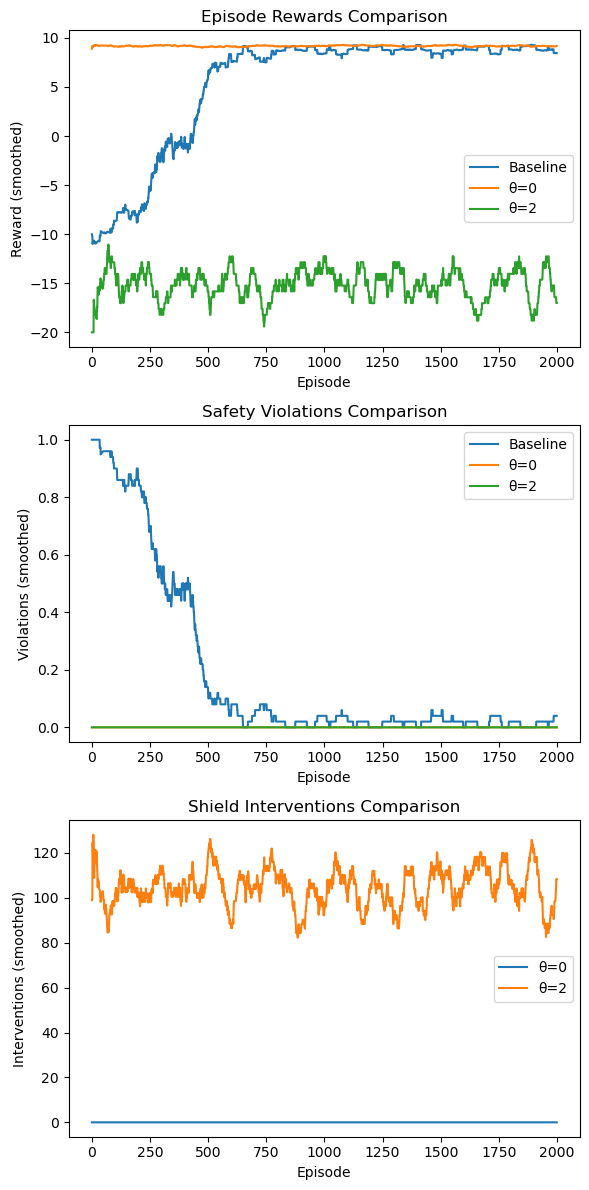

In [21]:
def smooth(data, window=50):
    dq = deque(maxlen=window)
    out = []
    for x in data:
        dq.append(x)
        out.append(np.mean(dq))
    return out

# def smooth(data, window=50):
#     return np.convolve(data, np.ones(window)/window, mode='same')

import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 1, figsize=(6,12))
ax_rewards, ax_violations, ax_interventions = axs

# Rewards
for name, r in results_task5.items():
    ax_rewards.plot(smooth(r['rewards']), label=name)
ax_rewards.set_title("Episode Rewards Comparison")
ax_rewards.set_ylabel("Reward (smoothed)")
ax_rewards.set_xlabel("Episode")
ax_rewards.legend()

# Safety Violations
for name, r in results_task5.items():
    ax_violations.plot(smooth(r['violations']), label=name)
ax_violations.set_title("Safety Violations Comparison")
ax_violations.set_ylabel("Violations (smoothed)")
ax_violations.set_xlabel("Episode")
ax_violations.legend()

# Shield Interventions (only shielded agents)
for name, r in results_task5.items():
    if name != 'Baseline':
        ax_interventions.plot(smooth(r['interventions']), label=name)
ax_interventions.set_title("Shield Interventions Comparison")
ax_interventions.set_ylabel("Interventions (smoothed)")
ax_interventions.set_xlabel("Episode")
ax_interventions.legend()

plt.tight_layout()
plt.show()


In [22]:
episodes = 2000
print("THRESHOLD COMPARISON SUMMARY")
print("="*50)
print(f"Episodes: {episodes}")

print("SAFETY VIOLATIONS:")
print(f"Baseline: {sum(results_task5['Baseline']['violations'])}")
for key in results_task5:
    if key != 'Baseline':
        total_viol = sum(results_task5[key]['violations'])
        reduction = 100 * (1 - total_viol / sum(results_task5['Baseline']['violations']))
        print(f"{key}: {total_viol} ({reduction:.1f}% reduction)")

print("SUCCESS RATE:")
print(f"Baseline: {np.mean(results_task5['Baseline']['success'])*100:.1f}%")
for key in results_task5:
    if key != 'Baseline':
        print(f"{key}: {np.mean(results_task5[key]['success'])*100:.1f}%")

print("INTERVENTIONS (total):")
for key in results_task5:
    if key != 'Baseline':
        total_intv = sum(results_task5[key]['interventions'])
        avg_intv = np.mean(results_task5[key]['interventions'])
        print(f"{key}: {total_intv} (avg: {avg_intv:.1f}/ep)")

print("FINAL REWARD (last 100 episodes):")
print(f"Baseline: {np.mean(results_task5['Baseline']['rewards'][-100:]):.1f}")
for key in results_task5:
    if key != 'Baseline':
        print(f"{key}: {np.mean(results_task5[key]['rewards'][-100:]):.1f}")

print("KEY INSIGHT:")
print("θ=0: Fewer interventions, faster learning")
print("θ=2: More interventions, maximum safety")


THRESHOLD COMPARISON SUMMARY
Episodes: 2000
SAFETY VIOLATIONS:
Baseline: 349
θ=0: 0 (100.0% reduction)
θ=2: 0 (100.0% reduction)
SUCCESS RATE:
Baseline: 82.5%
θ=0: 100.0%
θ=2: 16.4%
INTERVENTIONS (total):
θ=0: 0 (avg: 0.0/ep)
θ=2: 209229 (avg: 104.6/ep)
FINAL REWARD (last 100 episodes):
Baseline: 8.6
θ=0: 9.2
θ=2: -14.9
KEY INSIGHT:
θ=0: Fewer interventions, faster learning
θ=2: More interventions, maximum safety
